## Семинар 4: "Методы оптимизации"

ФИО: Мушенко Егор Сергеевич

In [1]:
from functools import partial

import numpy as np
import torch
import sys
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from torch.autograd import Variable
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
from IPython.display import clear_output
%matplotlib inline
plt.rc('animation', html='html5')

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.

### Часть 1: Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [3]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):   
        steps = np.arange(i+1)
        # left = max(0, i-20) # show last 20 steps
        left = 0
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)
    
    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

Сделаем задачу регрессии

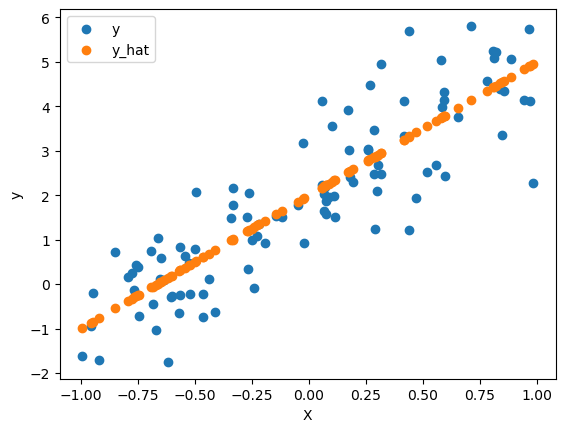

In [4]:
size = 100
X = torch.ones(size, 2)  # X[:, 1] = bias
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

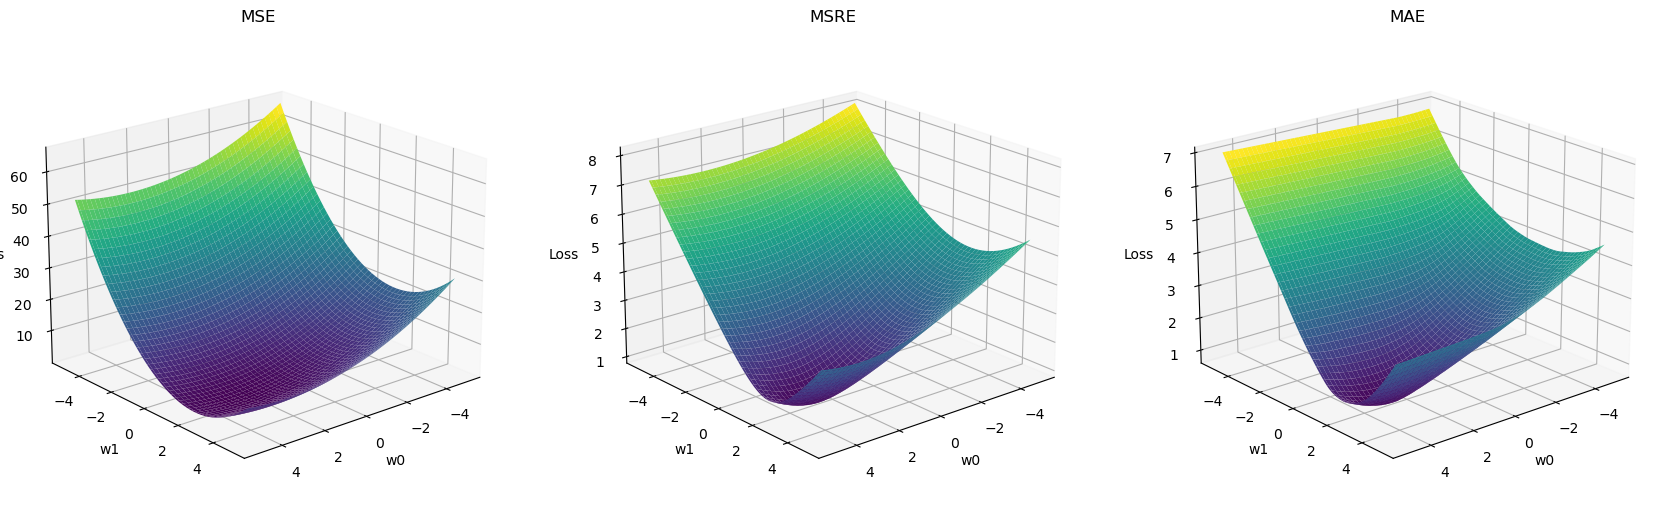

In [5]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуйте методы SGD, Momentum, NAG, Adagrad, Adadelta, Adam.</i> **(1 балл)**

In [6]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()
    
    def pre_step(self):
        pass
    
    def step(self):
        pass
    
    def update_param(self, p):
        raise NotImplementedError()


In [7]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses
    


In [8]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }
    
    return loss_animator.animate(num_iter, data, step_skip=step_skip)

In [9]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad
        

In [10]:
class Momentum(Optimizer):
    def __init__(self, params, lr=0.01, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.V = [torch.zeros_like(param) for param in self.params]

    def step(self):
        with torch.no_grad():
            for v, param in zip(self.V, self.params):
                v.copy_(self.gamma * v + self.lr * param.grad)
                param -= v

In [11]:
class NAG(Optimizer):
    def __init__(self, params, lr=0.01, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.V = [torch.zeros_like(param) for param in self.params]
        
    def step(self): 
        with torch.no_grad():
            for v, param in zip(self.V, self.params):
                param -= v

        with torch.no_grad():
            for v, param in zip(self.V, self.params):
                param += v
                v.copy_(self.gamma * v + self.lr * param.grad)
                param -= v

In [12]:
class RMSProp(Optimizer):
    def __init__(self, params, lr=0.01, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.G = [torch.zeros_like(param) for param in self.params]
        self.eps = 10e-8
    
    def step(self):
        with torch.no_grad():
            for g, param in zip(self.G, self.params):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                param -= self.lr / torch.sqrt(g + self.eps) * param.grad

In [13]:
class AdaGrad(Optimizer):
    def __init__(self, params, lr=0.01):
        super().__init__(params)
        self.lr = lr
        self.eps = 10e-8
        self.G = [torch.zeros_like(param) for param in self.params]
    
    def step(self):
        with torch.no_grad():
            for g, param in zip(self.G, self.params):
                g.copy_(g + param.grad**2)
                param -= self.lr / torch.sqrt(g + self.eps) * param.grad

In [14]:
class Adadelta(Optimizer):
    def __init__(self, params, gamma=0.9):
        super().__init__(params)
        
        self.gamma = gamma
        self.eps = 10e-8
        self.G = [torch.zeros_like(param) for param in self.params]
        self.D_Theta = [torch.zeros_like(param) for param in self.params]
        
    
    def step(self):
        with torch.no_grad():
            for g, d_theta, param in zip(self.G, self.D_Theta, self.params):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                param_hat = (torch.sqrt(d_theta + self.eps) / torch.sqrt(g + self.eps)) * param.grad
                d_theta.copy_(self.gamma * d_theta + (1 - self.gamma) * param_hat**2)
                param -= param_hat

In [15]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.01, beta_1=0.9, beta_2=0.99):
        super().__init__(params)
        
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = 10e-8

        self.M = [torch.zeros_like(param) for param in self.params]
        self.V = [torch.zeros_like(param) for param in self.params]
        
    def step(self):
        with torch.no_grad():
            for m, v, param in zip(self.M, self.V, self.params):
                m.copy_(self.beta_1 * m + (1 - self.beta_1) * param.grad)
                v.copy_(self.beta_2 * v + (1 - self.beta_2) * param.grad**2)
                m_hat = m / (1 - self.beta_1)
                v_hat = v / (1 - self.beta_2)
                param -= self.lr / torch.sqrt(v_hat + self.eps) * m_hat

In [16]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), SGD, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)

In [17]:
points.shape, losses.shape

(torch.Size([100, 2]), torch.Size([100]))

Text(0, 0.5, 'Loss')

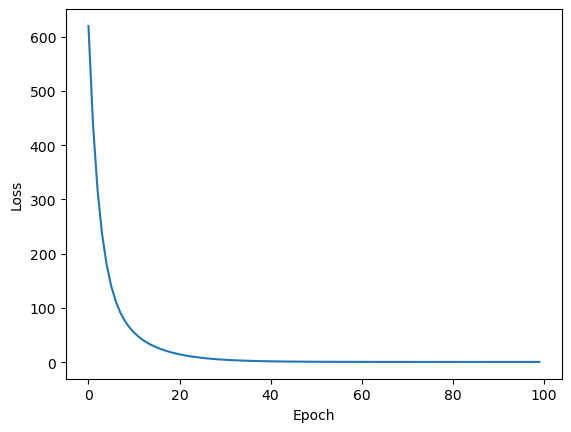

In [18]:
# Plot loss and name axes
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

<i1> 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

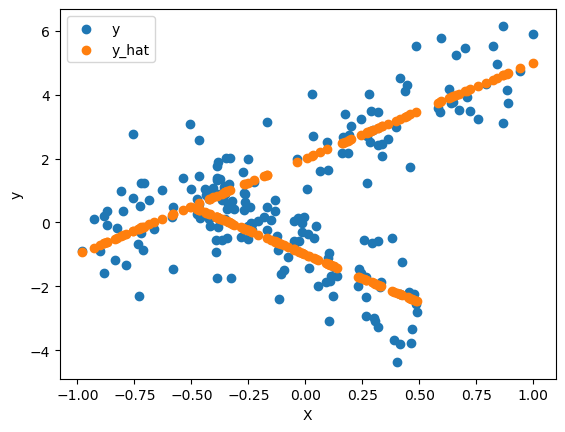

In [19]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

X2 = torch.ones(size, 2)
X2[:, 0].uniform_(-0.5, 0.5)

y_hat2 = -3 * X2[:, 0] - 1
y2 = y_hat2 + torch.randn(size)

X = torch.cat([X, X2], axis=0)
y = torch.cat([y, y2], axis=0)
y_hat = torch.cat([y_hat, y_hat2], axis=0)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

In [20]:
from torch.optim import SGD as TorchSGD

In [21]:
compare_optimizers(
    loss_animator, mse, 
    [
        ('SGD', SGD, {'lr': 1e-1}),
        ('TorchSGD', TorchSGD, {'lr': 1e-1}),
        ('TorchSGD_momentum', TorchSGD, {'lr': 1e-1, 'momentum': 0.9}),
    ],
    start_point=[-5, -5],
    num_iter=100,
    step_skip=1
)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i> **(2 балла)**

In [22]:
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz

In [23]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [24]:
def run_net_learning_process(net, optimizer, train_loader, test_loader, 
                             epochs, criterion,
                             plot=True, verbose=True, conv=False
):

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            num_of_correct_pred = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = Variable(data), Variable(target)
                if not conv:
                    data = data.view(-1, 28*28) # изменим размер с (batch_size, 1, 28, 28) на (batch_size, 28*28)
                optimizer.zero_grad()
                net_out = net(data)
                loss = criterion(net_out, target)
                losses.append(loss.data.item())

                pred = net_out.data.max(1)[1]
                num_of_correct_pred += pred.eq(target.data).sum().item()
                loss.backward()

                optimizer.step()

            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(num_of_correct_pred / len(train_loader.dataset))

            losses = []
            num_of_correct_pred = 0
            for data, target in test_loader:
                data, target = Variable(data), Variable(target)
                if not conv:
                    data = data.view(-1, 28 * 28)
                net_out = net(data)
 
                loss = criterion(net_out, target)
                losses.append(loss.data.item())

                # sum up batch loss
                pred = net_out.data.max(1)[1]
                num_of_correct_pred += pred.eq(target.data).sum().item()

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(num_of_correct_pred / len(test_loader.dataset))

            clear_output(wait=True) # для динамического обновления графиков, wait - очищает вывод

            if verbose:
                print(
                      f'Network: <{type(net).__name__}>\n'
                      f'Optimizer: <{type(optimizer).__name__}>\n'
                      f'Loss type: <{type(criterion).__name__}>\n\n'
                      f'Epoch: {epoch+1}\n'
                      f'<Train/Test>\n'
                      f'Loss: {np.round(train_loss_epochs[-1], 3)}/{np.round(test_loss_epochs[-1], 3)} '
                      f'| Accuracy: {np.round(train_accuracy_epochs[-1], 3)}/{np.round(test_accuracy_epochs[-1], 3)}'
                     )

            if plot:
                plt.figure(figsize=(12, 5))

                # Отображение изменения ошибки
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')

                # Отображение изменения accuracy
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train')
                plt.plot(test_accuracy_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt as KI:
        print(KI)

    return train_loss_epochs, \
       test_loss_epochs, \
       train_accuracy_epochs, \
       test_accuracy_epochs

In [25]:
def compare_activation_func(loss_results: list, acc_results: list, labels: list) -> None:
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    for loss_result, label in zip(loss_results, labels):
        plt.plot(loss_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=10)
    plt.grid()

    plt.subplot(1, 2, 2)
    for acc_result, label in zip(acc_results, labels):
        plt.plot(acc_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [27]:
NUM_EPOCHS=10
nets = [FullyConnectedNN() for i in range(7)]
print(nets[0])

FullyConnectedNN(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [28]:
optimizers = [
                SGD(params=nets[0].parameters(), lr=0.01),
                Momentum(params=nets[1].parameters(), lr=0.01, gamma=0.9),
                NAG(params=nets[2].parameters(), lr=0.01, gamma=0.9),
                RMSProp(params=nets[3].parameters(), lr=0.01, gamma=0.9),
                Adadelta(params=nets[4].parameters(), gamma=0.9),
                AdaGrad(params=nets[5].parameters(), lr=0.01),
                Adam(params=nets[6].parameters(), lr=0.005, beta_1=0.9, beta_2=0.99),
            ]
criterion = nn.NLLLoss()

Network: <FullyConnectedNN>
Optimizer: <SGD>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.068/0.085 | Accuracy: 0.981/0.973


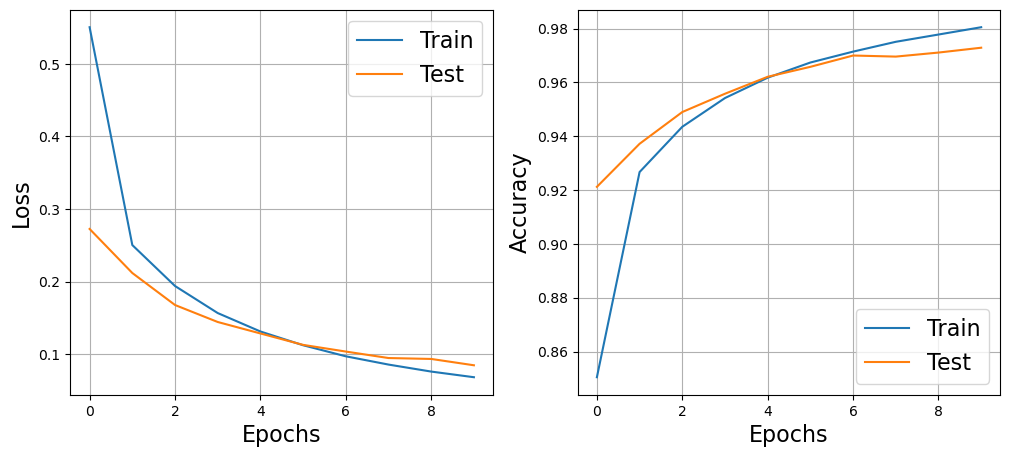

In [29]:
tr_sgd, ts_sgd, tr_ac_sgd, ts_ac_sgd =\
run_net_learning_process(net=nets[0], optimizer=optimizers[0], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True,
                        )

Network: <FullyConnectedNN>
Optimizer: <Momentum>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.018/0.078 | Accuracy: 0.993/0.982


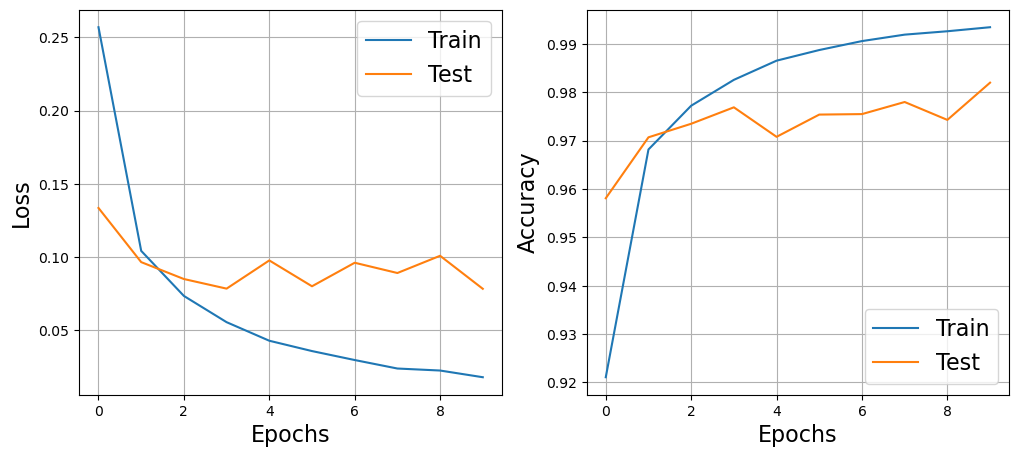

In [30]:
tr_mom, ts_mom, tr_ac_mom, ts_ac_mom =\
run_net_learning_process(net=nets[1], optimizer=optimizers[1], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True,
                        )

Network: <FullyConnectedNN>
Optimizer: <NAG>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.015/0.083 | Accuracy: 0.995/0.979


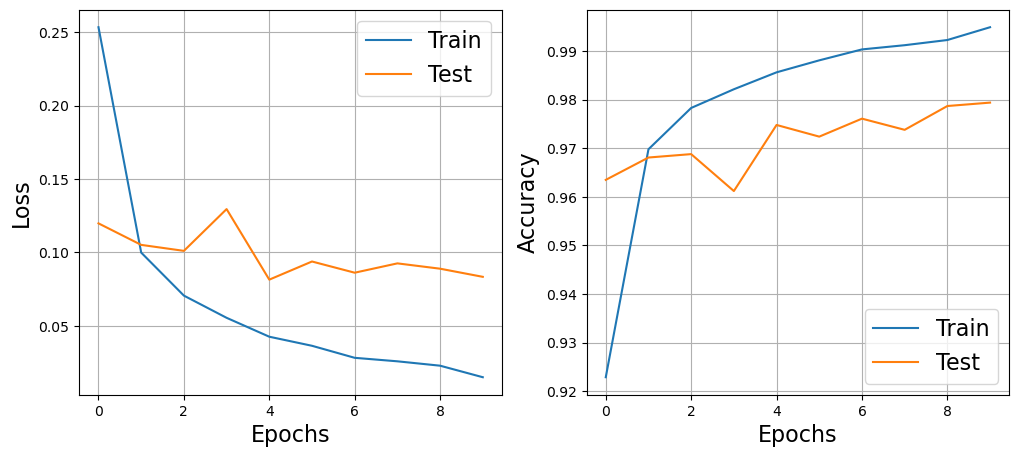

In [31]:
tr_nag, ts_nag, tr_ac_nag, ts_ac_nag =\
run_net_learning_process(net=nets[2], optimizer=optimizers[2], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True,
                        )

Network: <FullyConnectedNN>
Optimizer: <RMSProp>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.993/0.882 | Accuracy: 0.829/0.83


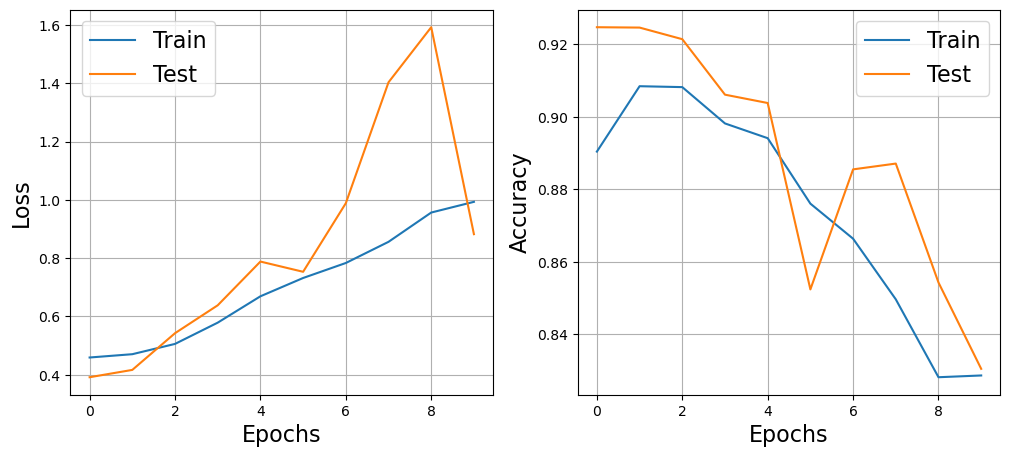

In [32]:
tr_rms, ts_rms, tr_ac_rms, ts_ac_rms =\
run_net_learning_process(net=nets[3], optimizer=optimizers[3], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True,
                        )

Network: <FullyConnectedNN>
Optimizer: <Adadelta>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.022/0.108 | Accuracy: 0.994/0.977


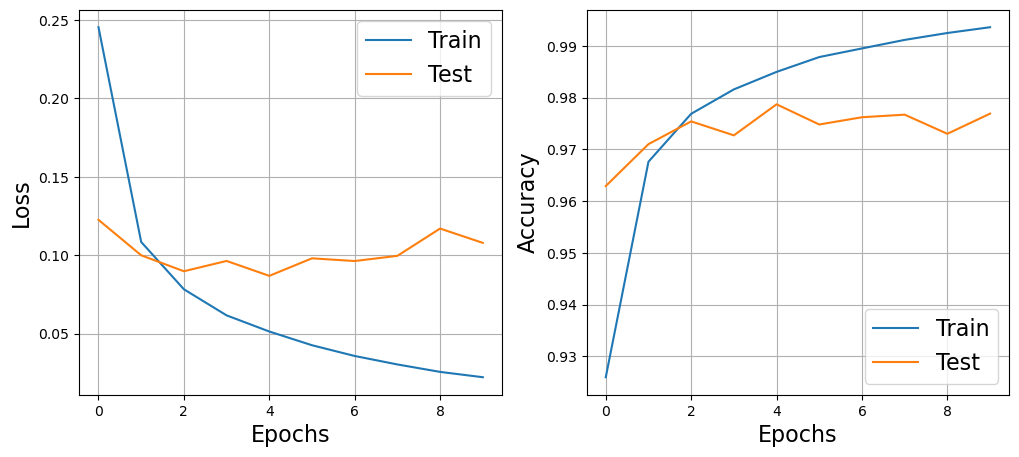

In [33]:
tr_add, ts_add, tr_ac_add, ts_ac_add =\
run_net_learning_process(net=nets[4], optimizer=optimizers[4], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True,
                        )

Network: <FullyConnectedNN>
Optimizer: <AdaGrad>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.042/0.068 | Accuracy: 0.988/0.977


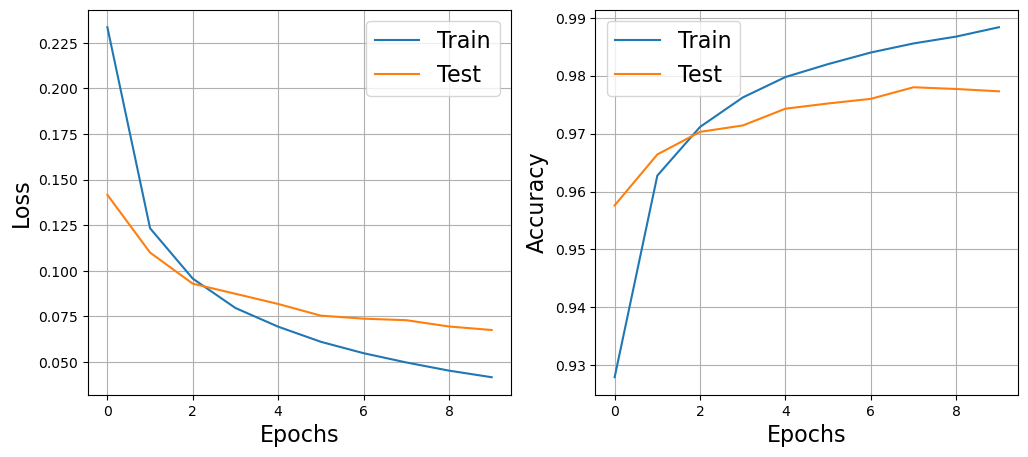

In [34]:
tr_adg, ts_adg, tr_ac_adg, ts_ac_adg =\
run_net_learning_process(net=nets[5], optimizer=optimizers[5], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True,
                        )

Network: <FullyConnectedNN>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.125/0.202 | Accuracy: 0.971/0.962


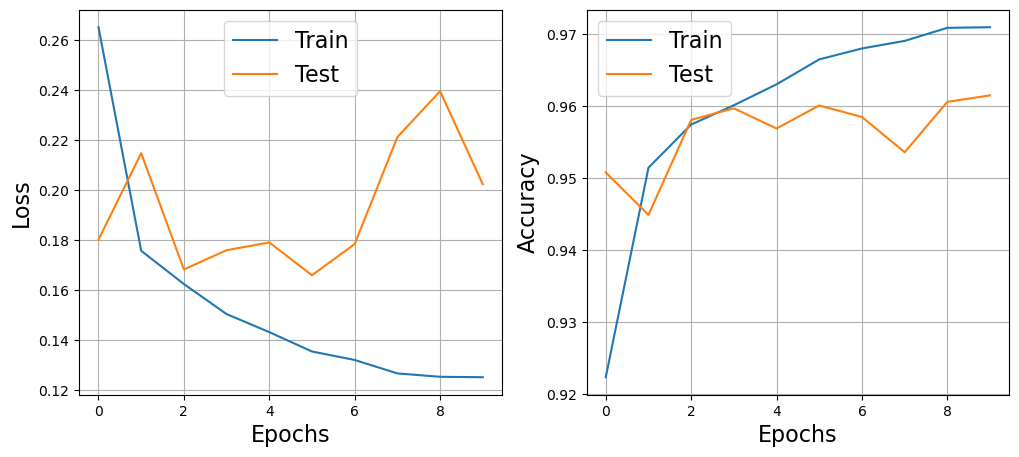

In [35]:
tr_adm, ts_adm, tr_ac_adm, ts_ac_adm =\
run_net_learning_process(net=nets[6], optimizer=optimizers[6], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True,
                        )

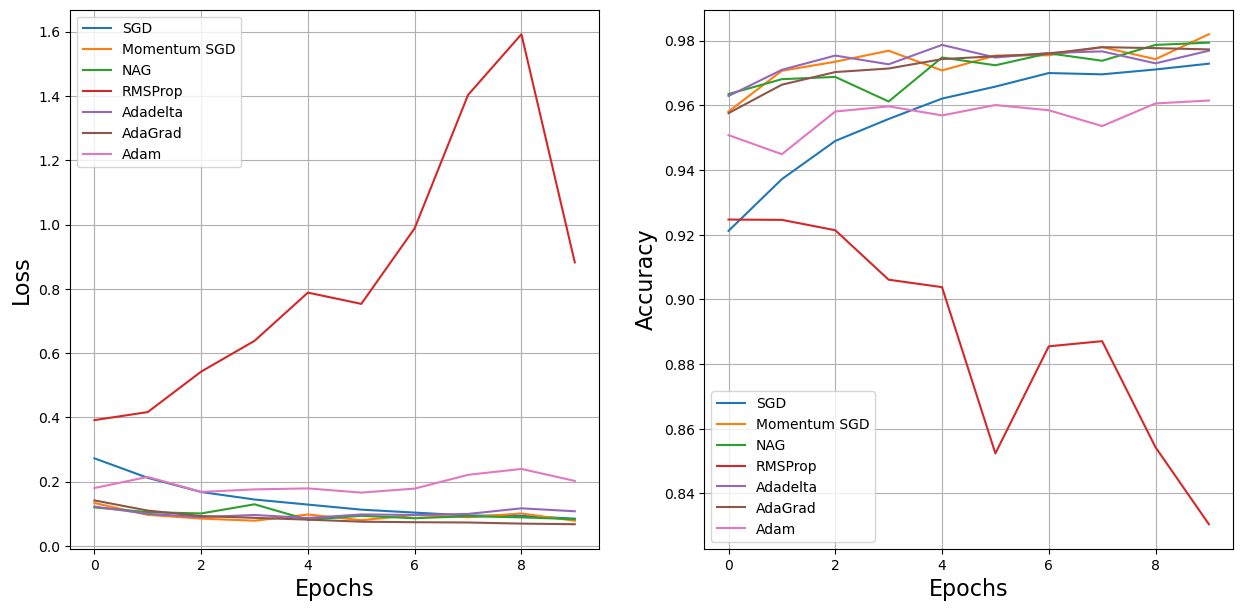

In [36]:
compare_activation_func(loss_results=[ts_sgd, ts_mom, ts_nag, ts_rms, ts_add, ts_adg, ts_adm], 
                        acc_results=[ts_ac_sgd, ts_ac_mom, ts_ac_nag, ts_ac_rms, ts_ac_add, ts_ac_adg, ts_ac_adm],
                        labels=["SGD", "Momentum SGD", "NAG", "RMSProp", "Adadelta", "AdaGrad", "Adam"])

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i> **(1 балл)**

In [37]:
IMAGE_SIZE = 28
CHANNELS = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(CHANNELS, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [38]:
NUM_EPOCHS=10
cnn_nets = [ConvClassifier(image_size=IMAGE_SIZE) for i in range(7)]
print(cnn_nets[0])

ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=588, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


In [39]:
optimizers = [
                SGD(params=cnn_nets[0].parameters(), lr=0.01),
                Momentum(params=cnn_nets[1].parameters(), lr=0.01, gamma=0.9),
                NAG(params=cnn_nets[2].parameters(), lr=0.01, gamma=0.9),
                RMSProp(params=cnn_nets[3].parameters(), lr=0.01, gamma=0.9),
                Adadelta(params=cnn_nets[4].parameters(), gamma=0.9),
                AdaGrad(params=cnn_nets[5].parameters(), lr=0.01),
                Adam(params=cnn_nets[6].parameters(), lr=0.005, beta_1=0.9, beta_2=0.99),
            ]
criterion = nn.NLLLoss()

Network: <ConvClassifier>
Optimizer: <SGD>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.093/0.091 | Accuracy: 0.973/0.97


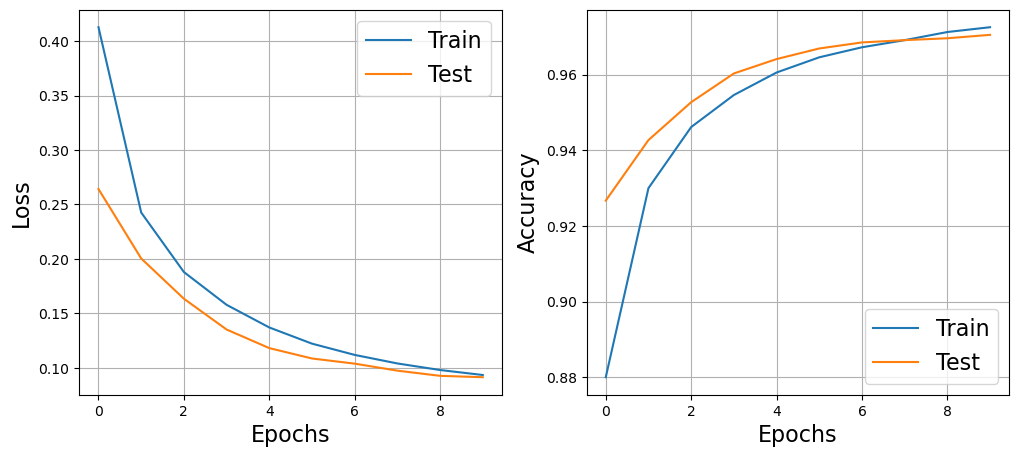

In [40]:
tr_sgd, ts_sgd, tr_ac_sgd, ts_ac_sgd =\
run_net_learning_process(net=cnn_nets[0], optimizer=optimizers[0], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True, conv=True,
                        )

Network: <ConvClassifier>
Optimizer: <Momentum>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.082/0.086 | Accuracy: 0.974/0.973


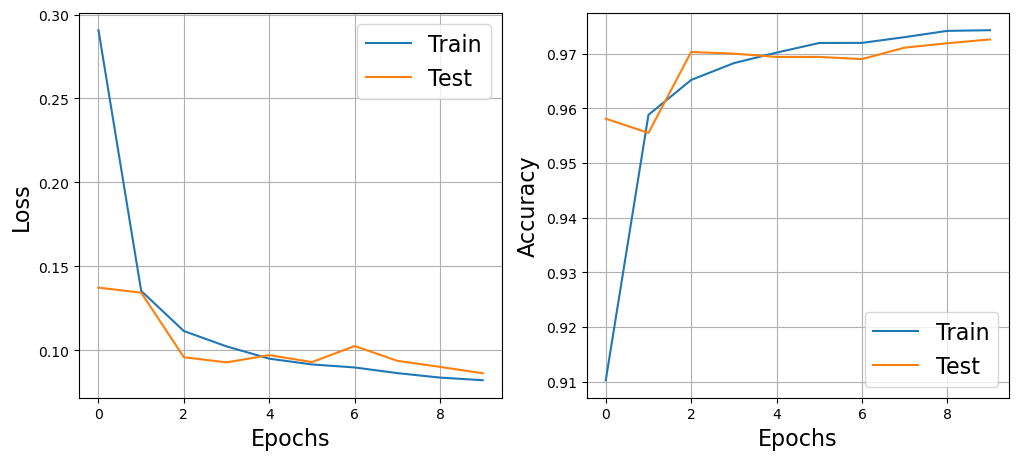

In [41]:
tr_mom, ts_mom, tr_ac_mom, ts_ac_mom =\
run_net_learning_process(net=cnn_nets[1], optimizer=optimizers[1], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True, conv=True,
                        )

Network: <ConvClassifier>
Optimizer: <NAG>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.086/0.095 | Accuracy: 0.974/0.97


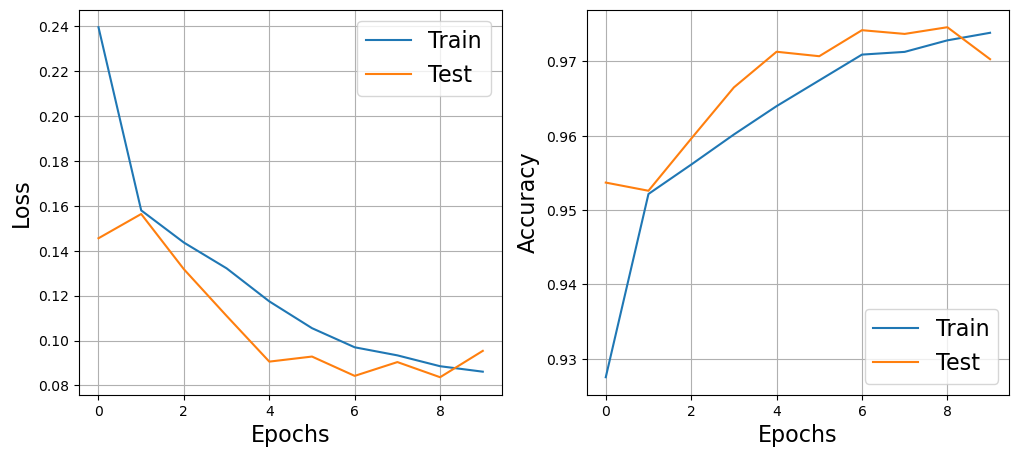

In [42]:
tr_nag, ts_nag, tr_ac_nag, ts_ac_nag =\
run_net_learning_process(net=cnn_nets[2], optimizer=optimizers[2], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True, conv=True,
                        )

Network: <ConvClassifier>
Optimizer: <RMSProp>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.121/0.101 | Accuracy: 0.967/0.968


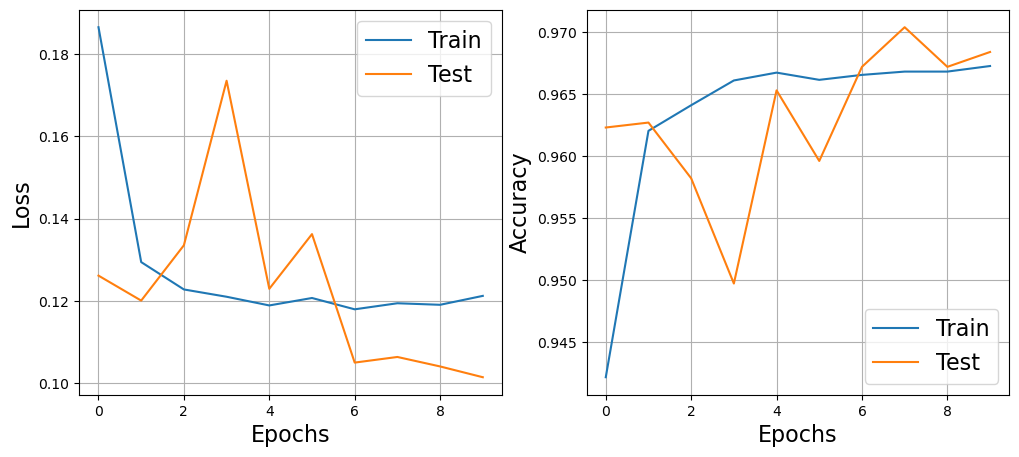

In [43]:
tr_rms, ts_rms, tr_ac_rms, ts_ac_rms =\
run_net_learning_process(net=cnn_nets[3], optimizer=optimizers[3], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True, conv=True,
                        )

Network: <ConvClassifier>
Optimizer: <Adadelta>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.102/0.104 | Accuracy: 0.97/0.969


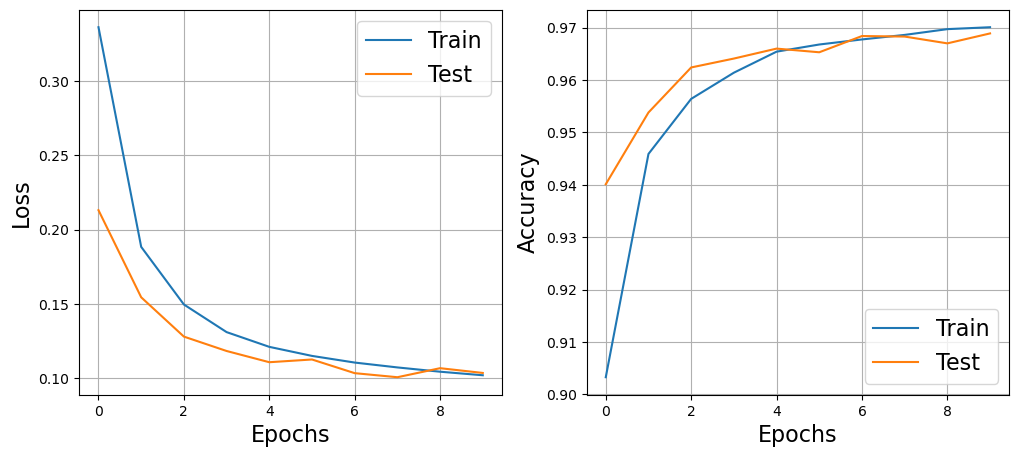

In [44]:
tr_add, ts_add, tr_ac_add, ts_ac_add =\
run_net_learning_process(net=cnn_nets[4], optimizer=optimizers[4], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True, conv=True,
                        )

Network: <ConvClassifier>
Optimizer: <AdaGrad>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.121/0.12 | Accuracy: 0.965/0.963


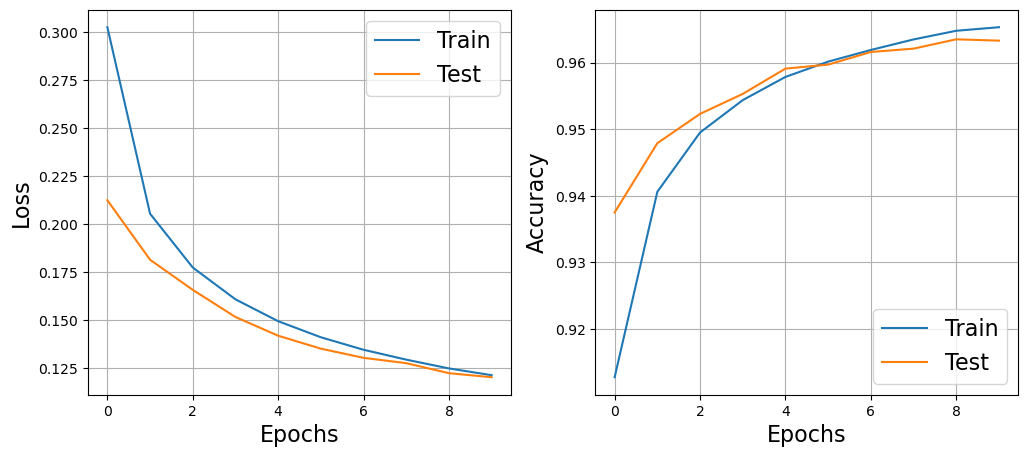

In [45]:
tr_adg, ts_adg, tr_ac_adg, ts_ac_adg =\
run_net_learning_process(net=cnn_nets[5], optimizer=optimizers[5], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True, conv=True,
                        )

Network: <ConvClassifier>
Optimizer: <Adam>
Loss type: <NLLLoss>

Epoch: 10
<Train/Test>
Loss: 0.074/0.098 | Accuracy: 0.977/0.97


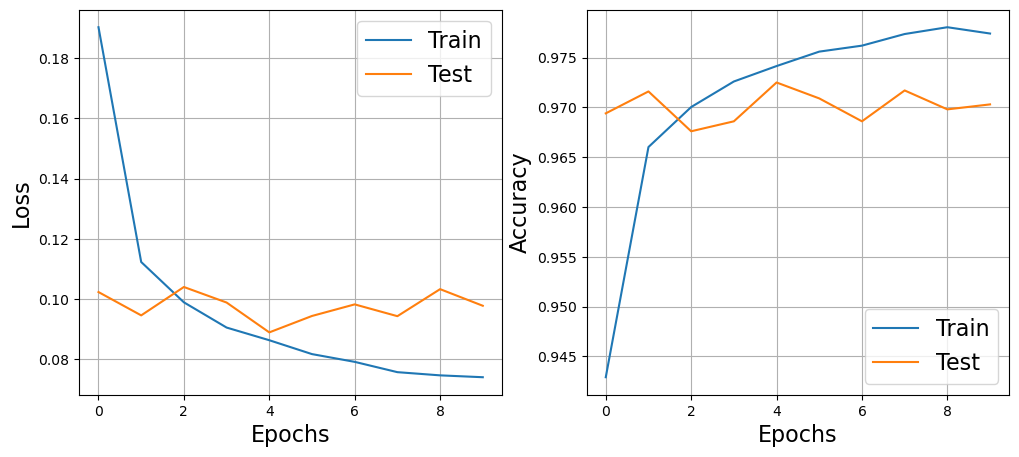

In [46]:
tr_adm, ts_adm, tr_ac_adm, ts_ac_adm =\
run_net_learning_process(net=cnn_nets[6], optimizer=optimizers[6], epochs=NUM_EPOCHS, criterion=criterion,
                         train_loader=train_loader, test_loader=test_loader, 
                         plot=True, verbose=True, conv=True,
                        )

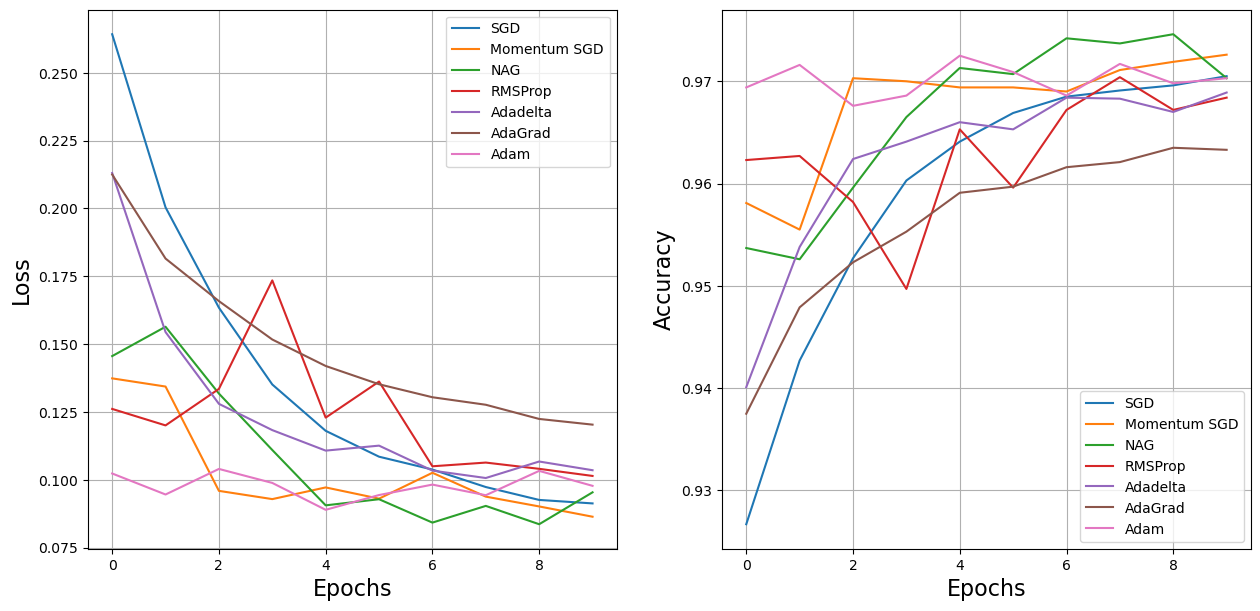

In [47]:
compare_activation_func(loss_results=[ts_sgd, ts_mom, ts_nag, ts_rms, ts_add, ts_adg, ts_adm], 
                        acc_results=[ts_ac_sgd, ts_ac_mom, ts_ac_nag, ts_ac_rms, ts_ac_add, ts_ac_adg, ts_ac_adm],
                        labels=["SGD", "Momentum SGD", "NAG", "RMSProp", "Adadelta", "AdaGrad", "Adam"])

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: